In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 1. 加载数据
try:
    df = pd.read_csv("数据/Project_Data_Cleaned.csv")
except FileNotFoundError:
    print("文件未找到。")
    pass

if 'CustomerID' in df.columns:
    df = df.drop('CustomerID', axis=1)

# 分离特征和目标
X = df.drop('Churn', axis=1)

In [5]:
# 2. 预处理：对类别特征进行独热编码，对数值特征保持不变

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
potential_cats = ['CityTier', 'AgeGroup', 'SatisfactionScore', 'Complain']
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in potential_cats:
    if col in numeric_cols:
        numeric_cols.remove(col)
        categorical_cols.append(col)

# 创建一个新的 DataFrame 用于相关性分析
df_corr_analysis = df[['Churn']].copy()

# 添加数值特征
for col in numeric_cols:
    df_corr_analysis[col] = df[col]

# 添加类别特征 (独热编码)
# 我们使用 pandas get_dummies 来简化这个过程，直接得到带列名的 DataFrame
X_categorical = df[categorical_cols].astype(str) # 确保全是字符串以便编码
X_dummies = pd.get_dummies(X_categorical)

# 合并
df_corr_analysis = pd.concat([df_corr_analysis, X_dummies], axis=1)

In [6]:
# 3. 计算相关系数并按绝对值筛选 (*** 修改部分 ***)

# 计算所有特征与 Churn 的相关系数
all_correlations = df_corr_analysis.corr()['Churn']

# 移除 'Churn' 自身
if 'Churn' in all_correlations:
    all_correlations = all_correlations.drop('Churn')

# 计算绝对值
abs_correlations = all_correlations.abs()

# 按绝对值降序排序，取前 10 个的索引
top_10_indices = abs_correlations.sort_values(ascending=False).head(10).index

# 根据索引取回原始的相关系数值（保留正负号）
top_10_features = all_correlations.loc[top_10_indices]

print("按绝对值大小排名的 Top 10 特征:")
print(top_10_features)

# 保存完整相关系数表
all_correlations.to_csv('feature_correlations.csv')

按绝对值大小排名的 Top 10 特征:
Tenure                                -0.315941
Complain_0                            -0.250188
Complain_1                             0.250188
MaritalStatus_Single                   0.180847
DaySinceLastOrder                     -0.155871
PreferedOrderCat_Mobile Phone          0.154387
DiscountAmount                        -0.154161
MaritalStatus_Married                 -0.151024
PreferedOrderCat_Laptop & Accessory   -0.133353
PreferedOrderCat_Household             0.113364
Name: Churn, dtype: float64


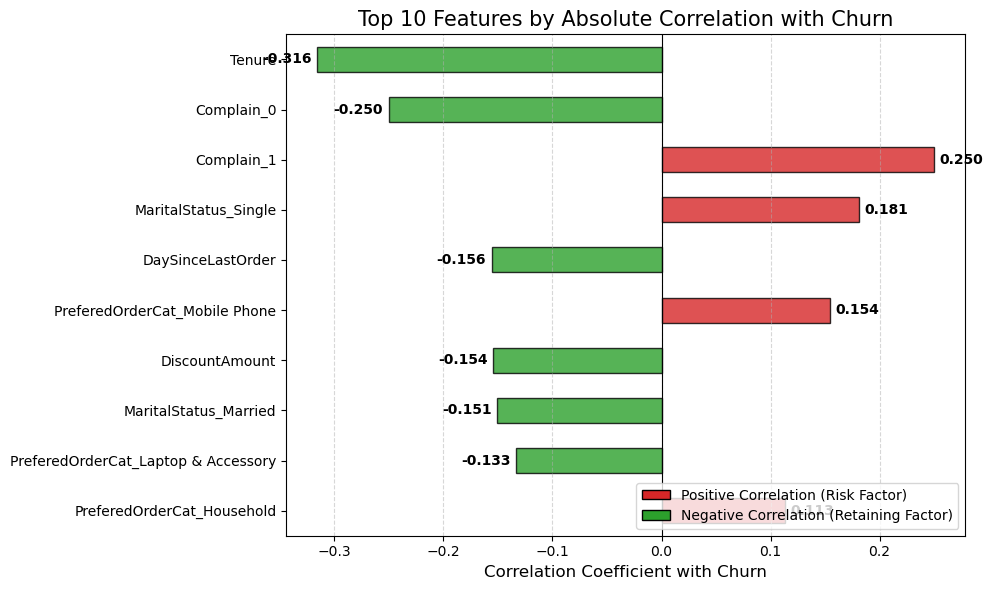

In [7]:
# 4. 可视化
plt.figure(figsize=(10, 6))

# 按绝对值从小到大排序（因为 barh 是从下往上画的）
top_10_sorted_for_plot = top_10_features.reindex(
    top_10_features.abs().sort_values(ascending=True).index
)

# 根据正负相关性设定颜色
colors = ['#d62728' if c > 0 else '#2ca02c' for c in top_10_sorted_for_plot.values]

# 绘制水平条形图
ax = top_10_sorted_for_plot.plot(kind='barh', color=colors, edgecolor='black', alpha=0.8)

# 添加数值标签
for i, v in enumerate(top_10_sorted_for_plot.values):
    # 根据数值的正负调整标签位置
    offset = 0.005 if v >= 0 else -0.005
    ha_align = 'left' if v >= 0 else 'right'
    ax.text(v + offset, i, f'{v:.3f}', va='center', ha=ha_align, fontsize=10, fontweight='bold')

plt.xlabel('Correlation Coefficient with Churn', fontsize=12)
plt.title('Top 10 Features by Absolute Correlation with Churn', fontsize=15)

# 添加图例说明颜色含义
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', edgecolor='black', label='Positive Correlation (Risk Factor)'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='Negative Correlation (Retaining Factor)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linewidth=0.8) # 添加0轴辅助线
plt.tight_layout()

# 保存并显示
# plt.savefig('top_10_abs_correlation.png')
# print("\nTop 10 相关系数图已保存为 'top_10_abs_correlation.png'")
plt.show()